In [1]:
from jax import numpy as jnp
from jax import vmap, grad, jit
import s2fft
from jax.scipy.special import sph_harm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import jax
jax.config.update("jax_enable_x64", True)

from jax import vmap
import jax.numpy as jnp
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import s2fft

JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


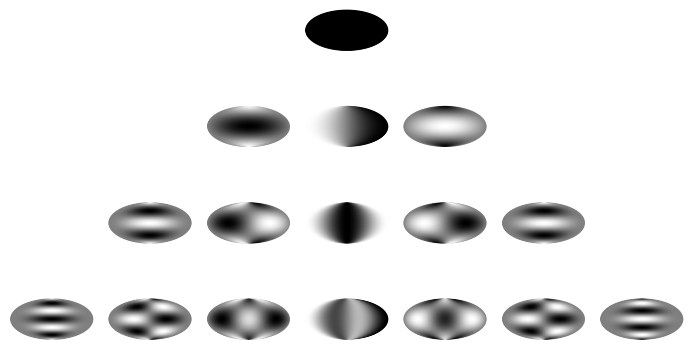

In [2]:

def colormap(x):
    cmap = plt.get_cmap('viridis', 256)
    return cmap(x)

def normalize(v):
    max = jnp.max(v)
    min = jnp.min(v)
    return (v - min) / (max - min)

def to_points(theta, phi):
    x = jnp.sin(phi) * jnp.cos(theta)
    y = jnp.sin(phi) * jnp.sin(theta)
    z = jnp.cos(phi)
    return x, y, z

def sph_plot(l, m, ax):
    theta = jnp.linspace(0, 2*jnp.pi, 100)
    phi = jnp.linspace(0, jnp.pi, 100)
    theta, phi = jnp.meshgrid(theta, phi, indexing='ij')
    yml = lambda theta, phi: sph_harm(jnp.array([m]), jnp.array([l]), jnp.array([theta]), jnp.array([phi]))
    v = vmap(vmap(yml, (0,0)), (0, 0))(theta, phi)
    v = normalize(v.real)
    c = colormap(v)
    x, y, z = to_points(theta, phi)
    #ax.plot_surface(x, y, z, facecolors=c, rstride=1, cstride=1, shade=False)
    ax.imshow(v, transform=ccrs.PlateCarree(), cmap='jet')

L = 4
M = 2*L + 1
s = 1.
plt.figure(figsize=(M*s, L*s))
for l in range(L):
    for m in range(-l, l+1):
        #ax = plt.subplot(L, M, L+1+m + M*l, projection='3d')
        ax = plt.subplot(L, M, L+1+m + M*l, projection=ccrs.Mollweide())
        sph_plot(l, m, ax)
        # set view in y-direction
        #ax.view_init(elev=0, azim=90)
        plt.axis("off")
plt.tight_layout()
        

In [3]:
f = jnp.load('data/Gaia_EDR3_flux.npy')
f = f[::9, ::9]
L = f.shape[0]
m_max = (f.shape[1]-1)//2

ls = jnp.arange(L).astype(jnp.int32)
ms = jnp.arange(-m_max, m_max+1).astype(jnp.int32)
Ls, Ms = jnp.meshgrid(ls, ms, indexing='ij')


sampling = "mw"
thetas = s2fft.sampling.s2_samples.thetas(L, sampling)
phis = s2fft.sampling.s2_samples.phis_equiang(L, sampling)

def func(theta, phi, flm, Ls, Ms):
    func_lm = lambda m, l: sph_harm(m, l, jnp.array([theta]), jnp.array([phi]), n_max=jnp.max(Ls))
    return jnp.sum(vmap(func_lm, (0, 0))(Ms, Ls) * flm)
    

In [ ]:
import time
flm = s2fft.forward_jax(f, L, sampling=sampling)
func_f = lambda theta, phi: func(theta, phi, flm, Ls, Ms)

t = time.time()
f_recov = s2fft.inverse_jax(flm, L, sampling=sampling)
t = time.time() - t
print(f"Fast Time: {t}")

t = time.time()
f_recov_scipy = vmap(vmap(func_f, (0, None)), (None, 0))(phis, thetas)
t = time.time() - t
print(f"Slow Time: {t}")

Fast Time: 0.9295048713684082
Slow Time: 1.0973172187805176


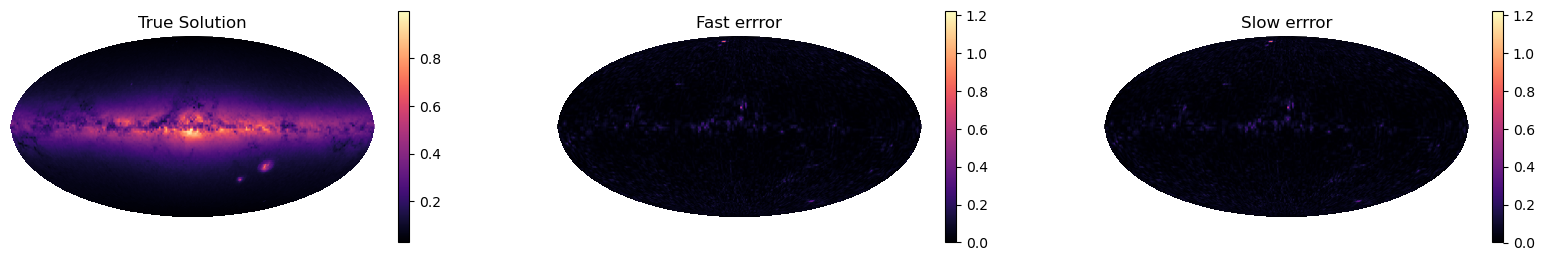

In [12]:
plt.figure(figsize=(20,3))
import jax.numpy as jnp

ax = plt.subplot(131, projection=ccrs.Mollweide())
plt.title("True Solution")
im = ax.imshow(f, transform=ccrs.PlateCarree(), cmap='magma')
plt.colorbar(im)
plt.axis('off')

ax = plt.subplot(132, projection=ccrs.Mollweide())
plt.title("Fast errror")
im = ax.imshow(jnp.abs(f_recov-f)/jnp.abs(f), transform=ccrs.PlateCarree(), cmap='magma')
plt.colorbar(im)
plt.axis('off')

ax = plt.subplot(133, projection=ccrs.Mollweide())
plt.title("Slow errror")
im = ax.imshow(jnp.abs(f_recov_scipy-f)/jnp.abs(f), transform=ccrs.PlateCarree(), cmap='magma')
plt.colorbar(im)
plt.axis('off')

plt.show()